## Detect & Track icebergs

In [5]:
import pandas as pd
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pickle
import wxee

import datetime as dt

import warnings
warnings.filterwarnings('ignore')

from sklearn import svm
from sklearn.metrics import confusion_matrix

from pkg_resources import resource_stream
from skimage import data, filters, color
from PIL import Image
import skimage.color
from skimage.segmentation import mark_boundaries
from pysnic.algorithms.snic import snic, compute_grid
from itertools import chain
from skimage.future import graph

from tqdm import tqdm

from scipy import stats

from skimage.measure import label, regionprops, regionprops_table
    
# Compare icebergs with  1d compromise
import matplotlib.patches as mpatches
from skimage.measure import profile_line

import pickle
import geemap
import ipywidgets as widgets

from ipyleaflet import WidgetControl

from pyproj import Proj, transform

# Import package for GEE
import ee

try:
    ee.Initialize()
    
except:
    ee.Authenticate()
    ee.Initialize()
    

In [6]:
# Functions to read images and process images (segmentation, classification)

def load_image(startdate, roi):
    # Function to load S1 images from Google Earth Engine
    # input
    # - startdate (str): start date of the imagery
    # - roi (ee geometry): search region of the imagery
    
    enddate = (dt.datetime.strptime(startdate, "%Y-%m-%d") + dt.timedelta(days = 1)).strftime("%Y-%m-%d")

    kernel = ee.Kernel.gaussian(3)

    S1 = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(roi)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
#     .filter(ee.Filter.eq('resolution', 'M'))
#     .sort('system:asset_size', False)

    img_list = S1.aggregate_array('system:id').getInfo()
    
    # Check the dimensions of the ee image -> select the largeset image
    dim = 0
    for i in range(0, len(img_list)):
        info = ee.Image(img_list[i]).clip(roi).getInfo()
        res = info['properties']['resolution_meters']
        test = np.prod(info['bands'][0]['dimensions']) * (res**2)
        if test > dim:
            dim = test
            ind = i

    if len(img_list) > 0:
        img_id = img_list[ind]
        print(img_id)

        band = ['HH', 'angle']
        imageA = ee.Image(img_id).select(band).clip(roi) # clip image into ROI
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH']) #.divide(img1.select(['angle']))
        angle = img1.select(['angle'])

        arr = img.wx.to_xarray(scale = 100, crs = "EPSG:3857", progress = False)
        arr_a = angle.wx.to_xarray(scale = 100, crs = "EPSG:3857", progress = False)

        a = np.array(arr["HH"])[0] / np.array(arr_a["angle"])[0]

        vmin = -1
        vmax = 0.5

        # Normalization (0-1)
        c = (a - vmin)/(vmax - vmin)
        c[c < 0] = 0; c[c > 1] = 1
        
        x = np.array(arr["x"])
        y = np.array(arr["y"])
        
        xx, yy = np.meshgrid(x, y)
        
        return c, xx, yy
        
    else:
        return np.array([np.nan]), np.array([np.nan]), np.array([np.nan])
        
def _weight_mean_color(graph, src, dst, n):
    diff = abs(graph.nodes[dst]['mean color'] - graph.nodes[n]['mean color'])
    diff = diff[0] #np.linalg.norm(diff)
    return {'weight': diff}

def merge_mean_color(graph, src, dst):
    graph.nodes[dst]['total color'] += graph.nodes[src]['total color']
    graph.nodes[dst]['pixel count'] += graph.nodes[src]['pixel count']
    graph.nodes[dst]['mean color'] = (graph.nodes[dst]['total color'] /
                                      graph.nodes[dst]['pixel count'])    

def hist_mode(c, bins = 100, ranges = (0.0, 1.0)):
    N, value = np.histogram(c.flatten(), bins = bins, range = ranges)
    mode = np.median([value[np.argmax(N)], value[np.argmax(N)+1]])
    return mode

def iceberg_segmentation(c):
    row, col = np.shape(c)
    c2 = np.expand_dims(c, axis=2)
    c3 = np.concatenate([c2, c2, c2], axis = 2)
    
    num_seg = int(row*col/50)
    seg_id = 0
    compactness = 0.02*(num_seg/100)

    grid = compute_grid(c3.shape, num_seg)
    seeds = []

    for s in list(chain.from_iterable(grid)):
        if c[s[1], s[0]] > 0:
            seeds.append(s)

    img = np.array(c3*255, dtype=np.uint8)
    img[img < 0] = 0
    img[img > 255] = 255

    lab_img = color.rgb2lab(c3).tolist()

    labels, _, centroids = snic(lab_img, seeds, compactness)
    labels = np.array(labels) + 1

    # edges = filters.sobel(color.rgb2gray(img))

    g = graph.rag_mean_color(img, labels) #.rag_boundary(labels, edges)

    mode = hist_mode(c)

    if mode < 0.5:
        th = 20 # 0.12
    else:
        th = 15 # 0.08

    seg_final = graph.merge_hierarchical(labels, g, thresh=th, rag_copy=False,
                                       in_place_merge=True,
                                       merge_func=merge_mean_color,
                                       weight_func=_weight_mean_color)
    return seg_final

def derive_inputs(c, shape, segment, coord):
    
    df = pd.DataFrame({})
    N = segment[(coord[1], coord[0])] # What segment?
    
    data = c[np.where(segment == N)]
    data = data[~np.isnan(data)]
    
    if len(data) > 0:
    
        # Location
        df.loc[0, 'x'] = coord[0]
        df.loc[0, 'y'] = coord[1]

        # Value statistics
        df.loc[0, 'v_mean'] = np.mean(data)
        df.loc[0, 'v_median'] = np.median(data)
        df.loc[0, 'v_max'] = np.max(data)
        df.loc[0, 'v_min'] = np.min(data)
        df.loc[0, 'v_contrast'] = np.max(data) - np.min(data)
        df.loc[0, 'v_std'] = np.std(data)
        df.loc[0, 'v_mode'] = hist_mode(data)
        df.loc[0, 'v_skew'] = stats.skew(data)
        df.loc[0, 'v_kurtosis'] = stats.kurtosis(data)
        df.loc[0, 'v_entropy'] = stats.entropy(data)
        df.loc[0, 'v_slope'] = np.polyfit(np.arange(len(data)), np.sort(data), 1)[0]

        # Shape parameters
        df.loc[0, 'convex_area'] = shape.loc[N, 'convex_area']
        df.loc[0, 'bbox_area'] = shape.loc[N, 'bbox_area']
        df.loc[0, 'perimeter'] = shape.loc[N, 'perimeter']
        df.loc[0, 'eccentricity'] = shape.loc[N, 'eccentricity']
        df.loc[0, 'eq_diameter'] = shape.loc[N, 'equivalent_diameter']
        df.loc[0, 'solidity'] = shape.loc[N, 'solidity']

    return df

def predict_iceberg(c, segment):
    model_dir = "F:\\Hackathon_polar_vertex\\Training\\models\\"
    model_file = model_dir + "SVM_linear.sav"

    rmodel = pickle.load(open(model_file, 'rb'))

    result = np.zeros(np.shape(segment))

    # Shape region parameters for each segment
    properties =['area','bbox', 'convex_area', 'bbox_area',
                 'major_axis_length', 'minor_axis_length', 'centroid',
                 'eccentricity', 'perimeter', 'equivalent_diameter', 'feret_diameter_max', 'solidity']

    shape = pd.DataFrame(regionprops_table(segment+1, intensity_image = c, properties = properties))

    for seg in np.unique(segment):
        if seg >= 0:
            if len(segment[np.where(segment == seg)]) > 2:
                y = np.where(segment == seg)[0][0]
                x = np.where(segment == seg)[1][0]
                df = derive_inputs(c, shape, segment, (x, y))

                if len(df) > 0:
                    inputs = ['v_mean', 'v_median', 'v_max', 'v_min', 'v_contrast', 'v_std',
                              'v_mode', 'v_skew', 'v_kurtosis', 'v_entropy', 'v_slope',
                              'perimeter', 'eccentricity', 'eq_diameter', 'solidity']

                    df2 = df.loc[:, inputs]
                    ib = rmodel.predict(df2)[0]
                    result[np.where(segment == seg)] = ib
                    shape.loc[seg, "iceberg"] = ib
    
    shape = shape.loc[shape["iceberg"] == 1, :].reset_index(drop = True)
    
    return result, shape

def read_lat():
    center_lat = float(input("LAT of center point: "))
    while center_lat > 90 or center_lat < -90:
        print("You entered wrong latitude. Latitude should be in [-90, 90]")
        center_lat = float(input("LAT of center point: "))
    return center_lat

def read_lon():
    center_lon = float(input("LON of center point: "))
    while center_lon > 180 or center_lon < -180:
        print("You entered wrong longitude. Longitude should be in [-180, 180]")
        center_lon = float(input("LON of center point: "))
    return center_lon

def read_date():
    correct_date = False
    date = input("DATE (YYYY-MM-DD): ") #'2021-06-11' # Test date

    while correct_date == False:
        try:
            dt.datetime.strptime(date, "%Y-%m-%d")
            
            c0, xx, yy = load_image(date, roi)

            if len(c0) > 1:
                correct_date = True
                return date, c0, xx, yy

            else:
                print("NO valid image on {0}. Please enter another day.".format(date))
                date = input("DATE (YYYY-MM-DD): ")
            
        except:
            print("You entered wrong date. Date should be formatted (YYYY-MM-DD).")
            date = input("DATE (YYYY-MM-DD): ")
            
        
            

In [7]:
# Functions to track icebergs

def create_1d_plot(subset, centroid, r, step = 4):
    angles = np.arange(0, 360+step, step)
    dist = np.zeros(len(angles))
    for i in range(0, len(angles)):        
        a = angles[i]
        target = (centroid[0]+r*np.cos(a*np.pi/180), centroid[1]+r*np.sin(a*np.pi/180))
        dist[i] = np.where(profile_line(subset, centroid, target) == 0)[0][0]
    return angles, dist

def match_profiles(v1, v2, diff = 0):
    v3 = np.array([])
    
    for N in range(0, len(v2)):
        d = (1-np.mean(abs(v1-np.roll(v2, N))/v1))*100
        r = np.corrcoef(v1, v2)[0,1]
        
        if d > diff and r > 0.7:
            diff = d
            v3 = np.roll(v2, N)
            
    return v3, diff

def track_icebergs(results, shapes, dates, th = 85, display = "y"):
    
    dayd = (dt.datetime.strptime(dates[1], "%Y-%m-%d") - dt.datetime.strptime(dates[0], "%Y-%m-%d")).days

    ind1 = []
    ind2 = []
    
    shape = shapes[0]
    result = results[0]
    
    shape2 = shapes[1]
    result2 = results[1]
    
    for i in tqdm(range(0, len(shape))):
        if (shape.loc[i, "iceberg"] == 1) and (shape.loc[i, "area"] < 10000) and (shape.loc[i, "area"] > 400):
            
            row = shape.loc[i, :]
            subset = result[int(row['bbox-0']):int(row['bbox-2']), int(row['bbox-1']):int(row['bbox-3'])]
            centroid = (row["centroid-0"]-row['bbox-0'], row["centroid-1"]-row['bbox-1'])
            r = 0.5*(np.shape(subset)[0]**2 + np.shape(subset)[1]**2)**0.5 + 100
            
            a, v0 = create_1d_plot(subset, centroid, r)
            
            score = th
            cand = np.where((abs(shape2['bbox-0']-row['bbox-0'])<100*dayd) &\
                            (abs(shape2['bbox-1']-row['bbox-1'])<100*dayd) &\
                           (shape2['area']>shape.loc[i,"area"]*0.7) &\
                           (shape2['area']<shape.loc[i,"area"]*1.3))[0]
            ind = np.nan
            
            # Find the candidate icebergs for the next image
            for j in cand:
                row2 = shape2.loc[j, :]

                subset2 = result2[int(row2['bbox-0']):int(row2['bbox-2']), int(row2['bbox-1']):int(row2['bbox-3'])]
                centroid2 = (row2["centroid-0"]-row2['bbox-0'], row2["centroid-1"]-row2['bbox-1'])
                r2 = 0.5*(np.shape(subset2)[0]**2 + np.shape(subset2)[1]**2)**0.5 + 100

                _, v2 = create_1d_plot(subset2, centroid2, r2)
                
                test = np.mean(abs(np.sort(v0) - np.sort(v2))/np.sort(v0))
                
                if test < 0.3:

                    v3, diff = match_profiles(v0, v2, score)

                    if diff > score:
                        score = diff
                        subsetf = subset2
                        vf = v3
                        ind = j
                        centroidf = centroid2
            
            
            if score > th:
                
                ind1.append(i)
                ind2.append(ind)
                
                if display == "y":
                
                    r = np.corrcoef(v0, vf)[0,1]
                    jind = np.mean(np.min([v0, vf], axis = 0)/np.max([v0, vf], axis = 0))*100

                    # Draw plots
                    fig, ax = plt.subplots(1, 3, figsize=(10, 2), dpi = 80, gridspec_kw={'width_ratios': [1,1,3]})

                    ax[0].set_title(dates[0] + " ({0})".format(i))
                    ax[0].imshow(subset, cmap = "gray", vmin = -0.5, vmax = 1.0);
                    ax[0].scatter(centroid[1], centroid[0])

                    ax[1].imshow(subsetf, cmap = "gray", vmin = -0.5, vmax = 1.0);
                    ax[1].set_title(dates[1] + " ({0})".format(ind))
                    ax[1].scatter(centroidf[1], centroidf[0])

                    ax[2].plot(a, v0, ls = "--", label = dates[0])
                    ax[2].plot(a, vf, label = dates[1])
                    ax[2].legend(loc = "upper right")
                    ymin, ymax = ax[2].set_ylim()
                    ax[2].text(-10, ymax-0.1*(ymax-ymin), "R={0:.2f}".format(r))
                    ax[2].text(-10, ymax-0.2*(ymax-ymin), "D={0:.2f}%".format(score))
                    ax[2].text(-10, ymax-0.3*(ymax-ymin), "J={0:.2f}%".format(jind))
                    
    return ind1, ind2

def display_map(results, segments, shapes, ind1, ind2):
    
    rows, cols = np.shape(results[0])
    
    fig, ax = plt.subplots(1,2,figsize = (14,7))
    ax[0].imshow(mark_boundaries(results[0], segments[0]), cmap = "gray", vmin = 0, vmax = 1.0)
    ax[1].imshow(mark_boundaries(results[1], segments[1]), cmap = "gray", vmin = 0, vmax = 1.0)

    cmap = matplotlib.cm.get_cmap('jet')

    for i in range(0, len(ind1)):

        rgba = cmap(i/len(ind1))

        row1 = shapes[0].loc[ind1[i], :]
        row2 = shapes[1].loc[ind2[i], :]

        patch = mpatches.Rectangle((row1['bbox-1'], row1['bbox-0']), row1['bbox-3']-row1['bbox-1'],
                                   row1['bbox-2']-row1['bbox-0'], edgecolor=rgba, facecolor='none')
        ax[0].add_patch(patch)

        patch2 = mpatches.Rectangle((row2['bbox-1'], row2['bbox-0']), row2['bbox-3']-row2['bbox-1'],
                                   row2['bbox-2']-row2['bbox-0'], edgecolor=rgba, facecolor='none')
        ax[1].add_patch(patch2)

        ax[0].arrow(row1["centroid-1"], row1["centroid-0"],
                    row2["centroid-1"]-row1["centroid-1"], row2["centroid-0"]-row1["centroid-0"],
                    color = rgba, width = 1, head_width = 8)
        ax[1].arrow(row1["centroid-1"], row1["centroid-0"],
                    row2["centroid-1"]-row1["centroid-1"], row2["centroid-0"]-row1["centroid-0"],
                    color = rgba, width = 1, head_width = 8)
        
    ax[0].set_xlim(0, cols); ax[0].set_ylim(0, rows)
    ax[1].set_xlim(0, cols); ax[1].set_ylim(0, rows)

def convert_latlon(shapes, xx, yy):
    y1 = np.array(shapes['centroid-0'].astype(int))
    x1 = np.array(shapes['centroid-1'].astype(int))

    P3857 = Proj(init='epsg:3857')
    P4326 = Proj(init='epsg:4326')

    lon1, lat1 = transform(P3857, P4326, xx[y1, x1], yy[y1, x1])
    shapes["lat"] = lat1
    shapes["lon"] = lon1
    
    return shapes

## 1. Enter your region of interest

In [8]:
## Option 1. Draw a point on the map
print("Draw a 'POINT' on the map!")

Map = geemap.Map(center = [-72, -100], zoom = 3)

Map.add_basemap('HYBRID')

# Add an output widget to the map
output_widget = widgets.Output(layout={'border': '1px solid black'})
output_control = WidgetControl(widget=output_widget, position='bottomright')
Map.add_control(output_control)

# Capture user interaction with the map
def handle_interaction(**kwargs):
    latlon = kwargs.get('coordinates')
    if kwargs.get('type') == 'click':
        Map.default_style = {'cursor': 'wait'}
        # xy = ee.Geometry.Point(latlon[::-1])

        with output_widget:
            
            output_widget.clear_output()
            print("Current Location: \n", latlon)
    Map.default_style = {'cursor': 'pointer'}

Map.on_interaction(handle_interaction)

Map

Draw a 'POINT' on the map!


Map(center=[-72, -100], controls=(WidgetControl(options=['position'], widget=HBox(children=(ToggleButton(value…

In [184]:
center_lon, center_lat = Map.draw_last_feature.getInfo()['geometry']['coordinates']

print("1. Region of interest")
print("LAT of center point: ", center_lat)
print("LON of center point: ", center_lon)

center = [center_lon, center_lat] # Amundsen Sea

xwin = 0.5
ywin = 0.15

roi = ee.Geometry.Rectangle([center[0]-xwin, center[1]-ywin, center[0]+xwin, center[1]+ywin])

1. Region of interest
LAT of center point:  -74.070385
LON of center point:  -109.088113


In [70]:
## Option 2. Input specific latitude & longitude

# print("1. Enter the latitude/longitude of your region of interest")
# center_lat = read_lat()
# center_lon = read_lon()

# center = [center_lon, center_lat] # Amundsen Sea

# xwin = 0.5
# ywin = 0.15

# roi = ee.Geometry.Rectangle([center[0]-xwin, center[1]-ywin, center[0]+xwin, center[1]+ywin])

## 2. Enter the start and end dates for tracking


2. Enter the start date
DATE (YYYY-MM-DD): 2019-07-01
COPERNICUS/S1_GRD/S1A_EW_GRDM_1SSH_20190701T041142_20190701T041234_027918_0326ED_BC82

3. Enter the end date
DATE (YYYY-MM-DD): 2019-07-02
NO valid image on 2019-07-02. Please enter another day.
DATE (YYYY-MM-DD): 2019-07-03
NO valid image on 2019-07-03. Please enter another day.
DATE (YYYY-MM-DD): 2019-07-04
COPERNICUS/S1_GRD/S1A_IW_GRDH_1SSH_20190704T043645_20190704T043712_027962_032846_56BF

# CENTER POINT:  [-109.088113, -74.070385]
# DATE: 2019-07-01 -> 2019-07-04

Processing 2019-07-01 data... 
Processing 2019-07-04 data... 
Start tracking process ...


100%|██████████| 198/198 [00:08<00:00, 22.33it/s]


DONE!


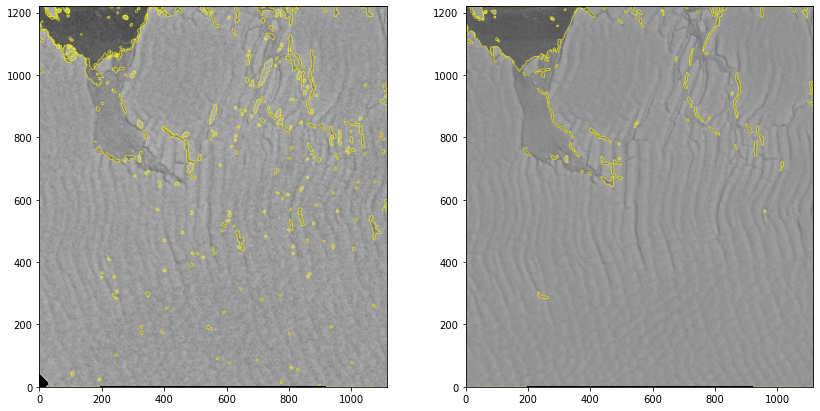

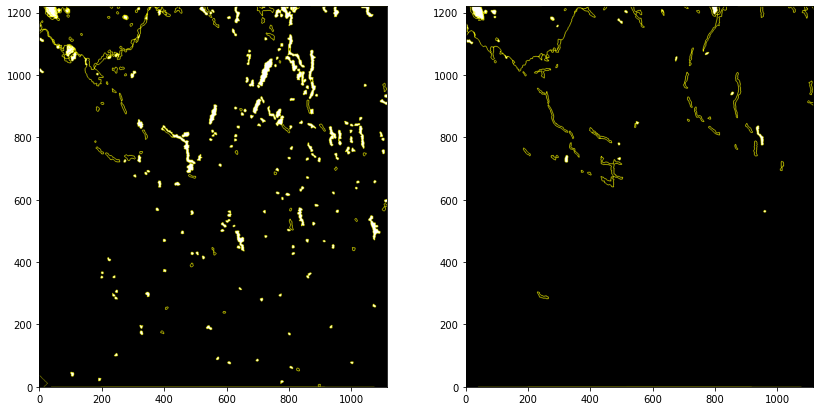

In [202]:
correct_date = False
print("\n2. Enter the start date")
date1, c0, xx, yy = read_date()

print("\n3. Enter the end date")
date2, c1, _, _ = read_date()

print("\n=================================")
print("# CENTER POINT: ", center)
print("# DATE: {0} -> {1}".format(date1, date2))
print("=================================\n")

cs = [c0, c1]
dates = [date1, date2]

segments = []
results = []
shapes = []

for i in [0, 1]:
    
    print("Processing {0} data... ".format(dates[i]))
    
    c = cs[i]
    segment = iceberg_segmentation(c)
    result, shape = predict_iceberg(c, segment)

    segments.append(segment)
    results.append(result)
    shapes.append(shape)
    
print("Start tracking process ...")

display = "y" # input("Do you want to display the 1-D shape profiles of icebergs? (y/n) ")
ind1, ind2 = track_icebergs(results, shapes, dates, 80, display)

target1 = convert_latlon(shapes[0], xx, yy).reset_index(drop = True)
target2 = convert_latlon(shapes[1], xx, yy).reset_index(drop = True)

display_map(cs, segments, shapes, ind1, ind2)
display_map(results, segments, shapes, ind1, ind2)

print("DONE!")